In [5]:
import torch
import numpy as np
import gym
import PIL
from torch import nn
from collections import namedtuple

## find a propper resolution in space and time

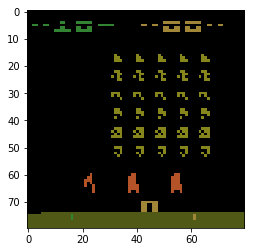

In [7]:
import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
import time
%matplotlib inline

SPACE_RES = (80,80)
TIME_RES = 3

def resize(obs):
    return np.array(PIL.Image.fromarray(obs).resize(SPACE_RES)) # , PIL.Image.BILINEAR)

def sample_steps(action, env, sample_size):
    samples = []
    info = []
    done = False
    reward = 0
    for i in range(sample_size):
 
        (_, r, d, i) = env.step(action)
        samples.append(env.render(mode='rgb_array'))
        done = done or d
        reward += r
        info = i
    
    obs = np.mean(samples, axis=0).astype('uint8')
#    obs = samples[0]
    return obs, reward, info, done
        

env = gym.make('SpaceInvaders-v0')
env.reset()
obs = resize(env.render(mode='rgb_array'))
img = plt.imshow(obs)
done = False
for i in range(200):
    time.sleep(0.05*TIME_RES)
    action = env.action_space.sample()
    obs, r, _, done = sample_steps(action, env, TIME_RES)
    obs = resize(obs)
    img.set_data(obs)
    display.display(plt.gcf())
    display.clear_output(wait=True)


## define torch value function  cnn

In [8]:
class ValueNet(nn.Module):
    def __init__(self):
        super(ValueNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(20 * 20 * 64, 100)
        self.fc2 = nn.Linear(100, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [9]:
def obs2tensor(obs):
    x = torch.tensor(obs, dtype=torch.float64)
    x = (x - x.mean()) / x.std()
    x = x.unsqueeze(0)
    x = x.permute(0,3,1,2)
    x = x.type(torch.FloatTensor)
    return x
net = ValueNet()
net(obs2tensor(obs))

tensor([[-0.1580,  0.1272, -0.2902,  0.1756, -0.2005,  0.1718,  0.2523,  0.2201,
          0.0744,  0.3826]], grad_fn=<AddmmBackward>)

## define Q function

## define game state Memory

In [10]:
MemRow = namedtuple('MemRow', ['action', 'obs', 'reward', 'done', 'next_obs'])



In [11]:
memory = []
memory.append(MemRow(obs=obs,
                     reward=reward,
                     done=done,
                     next_obs=next_obs,
                     action=action))


NameError: name 'reward' is not defined

## define QFunction

In [12]:
def q_func(value_net, reward, next_obs, decay=0.9):
    q = reward + decay * value_net(next_obs)
    return q

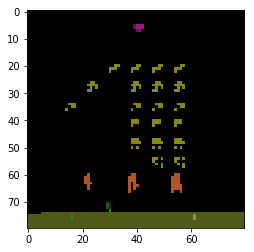

In [14]:
import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
import time
%matplotlib inline

GAMES = 2
        
memory = []

env = gym.make('SpaceInvaders-v0')
for game in range(GAMES):
    game_score = 0
    lives = 3
    done = False
    env.reset()
    obs = resize(env.render(mode='rgb_array'))
    img = plt.imshow(obs)
    while not done:
        #time.sleep(0.02*TIME_RES)
        action = env.action_space.sample()
        next_obs, score, info, done = sample_steps(action, env, TIME_RES)
        game_score += score
        reward = score/200
        next_obs = resize(next_obs)
        memory.append(MemRow(obs=obs,
                         reward=reward,
                         done=done,
                         next_obs=next_obs,
                         action=action))
        if info['ale.lives'] < lives:
            lives = info['ale.lives']
            reward = -1

        img.set_data(obs)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        obs = next_obs